### Introduction

This project integrates the Hodgkin-Huxley model with machine learning (ML) classifiers to explore the classification of neuron types based on their electrophysiological activity. The Hodgkin-Huxley model, a fundamental framework in neuroscience, describes the dynamics of membrane potentials through sodium and potassium ion channels. By extracting key features from action potentials (e.g., spike amplitude, action potential duration), we utilize ML classifiers to distinguish between motor neurons, sensory neurons, and interneurons. This approach offers a robust fusion of computational neuroscience and ML, aiming to improve neuron classification accuracy, a critical task for understanding neurological disorders and therapies.

The ML classifiers—Random Forest, XGBoost, SVM, and Neural Network—are rigorously evaluated through 5-fold stratified cross-validation, ensuring that neuron type distributions are preserved across training and testing. The comparison is credible due to careful feature scaling and consistent data splitting strategies, allowing for valid performance assessment of each model. Through this investigation, we aim to determine which model offers the most accurate and reliable classification for advancing neuroscience research.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

### Description

This section imports essential Python libraries required for numerical computations, data manipulation, and visualization:

- **NumPy (`numpy`)**: Provides support for large, multi-dimensional arrays and matrices, along with mathematical functions to operate on these arrays.

- **Matplotlib (`matplotlib.pyplot`)**: Used for creating static and interactive visualizations in Python, essential for plotting action potentials and other graphs.

- **SciPy (`scipy.integrate.odeint`)**: Offers algorithms for integrating ordinary differential equations (ODEs). The `odeint` function integrates a system of ODEs given initial conditions.

- **Pandas (`pandas`)**: Provides data structures and data analysis tools, particularly useful for handling tabular data (DataFrames).

These libraries are paramount for projects associated with computational neuroscience. They enable efficient numerical simulations of mathematical models like the Hodgkin-Huxley equations, data manipulation for feature extraction, and visualization for interpreting results.

In [3]:
# Membrane capacitance (μF/cm²)
C_m = 1.0

# Maximum conductances (mS/cm²)
g_Na = 120.0  # Sodium maximum conductance
g_K = 36.0    # Potassium maximum conductance
g_L = 0.3     # Leak maximum conductance

# Reversal potentials (mV)
E_Na = 50.0    # Sodium reversal potential
E_K = -77.0    # Potassium reversal potential
E_L = -54.387  # Leak reversal potential


### Description

This section defines key biophysical constants incorporated within the construct of the Hodgkin-Huxley model, which are grounded in empirical neurophysiological data.

- **Membrane Capacitance ($ C_m $)**: Set at $1.0 \, \mu\text{F}/\text{cm}^2$, representing the membrane’s charge storage capability. This value reflects the average capacitance of neuronal membranes and influences how fast the membrane potential responds to ion flows.

- **Maximum Conductances**: These constants quantify the maximum ion flow through specific channels when fully open:
    - **$ g_{\text{Na}} $** ($120.0 \, \text{mS}/\text{cm}^2$): Reflects the high sodium permeability during an action potential's rising phase. Sodium channels exhibit fast kinetics, creating a rapid depolarization spike.
    - **$ g_{\text{K}} $** ($36.0 \, \text{mS}/\text{cm}^2$): Governs potassium ion efflux during repolarization. Potassium channels, slower to open than sodium channels, contribute to restoring the resting potential after depolarization.
    - **$ g_{\text{L}} $** ($0.3 \, \text{mS}/\text{cm}^2$): Represents the constant leak conductance, accounting for passive ion flows that contribute to resting membrane potential.

- **Reversal Potentials**: The potentials at which no net ion flow occurs:
    - **$ E_{\text{Na}} $** ($50.0 \, \text{mV}$): Sodium reversal potential, set based on the intracellular and extracellular sodium concentration differences.
    - **$ E_{\text{K}} $** ($-77.0 \, \text{mV}$): Potassium reversal potential, reflecting its role in maintaining the resting potential.
    - **$ E_{\text{L}} $** ($-54.387 \, \text{mV}$): Leak reversal potential, contributing to the equilibrium potential in the absence of stimulation.

### Mathematical Formulas and Expressions

These constants feed directly into the Hodgkin-Huxley equations:

1. **Membrane Current Equation**:
   $$
   C_m \frac{dV}{dt} = I_{\text{ext}}(t) - I_{\text{Na}} - I_{\text{K}} - I_{\text{L}}
   $$
   where $ I_{\text{ext}}(t) $ is the external current applied to the neuron.

2. **Ionic Currents**:
   - **Sodium Current**:
     $$
     I_{\text{Na}} = g_{\text{Na}} m^3 h (V - E_{\text{Na}})
     $$
   - **Potassium Current**:
     $$
     I_{\text{K}} = g_{\text{K}} n^4 (V - E_{\text{K}})
     $$
   - **Leak Current**:
     $$
     I_{\text{L}} = g_{\text{L}} (V - E_{\text{L}})
     $$
   Here, $m$, $h$, and $n$ represent the gating variables, which model the probability of ion channels being open.

### Medical Explanation of the Parameters 

- **Membrane Capacitance ($ C_m $)**: Delineates the neuron’s ability to store charge, directly influencing the timing of voltage changes and action potential generation. A higher capacitance indicates slower voltage changes, while a lower capacitance leads to faster dynamics in response to ion currents.

- **Maximum Conductances**: The conductances $ g_{\text{Na}} $, $ g_{\text{K}} $, and $ g_{\text{L}} $ represent the maximum possible ion flow through their respective channels under full activation. These values reflect ion permeability and are essential for modeling neuronal excitability:
    - **$ g_{\text{Na}} $**: A high value emphasizes the importance of rapid sodium influx during the depolarization phase, crucial for generating fast action potentials.
    - **$ g_{\text{K}} $**: Potassium outflow is slower but critical for repolarizing the neuron after an action potential, helping reset the membrane potential.
    - **$ g_{\text{L}} $**: Represents the background ion leakage across the membrane, crucial for maintaining the resting membrane potential.

- **Reversal Potentials**: Each reversal potential reflects the equilibrium state for a particular ion species:
    - **$ E_{\text{Na}} $**: Reflects the sodium equilibrium potential based on its concentration gradient, contributing to the upstroke of the action potential.
    - **$ E_{\text{K}} $**: The potassium reversal potential is vital in establishing the resting potential and in repolarizing the membrane.
    - **$ E_{\text{L}} $**: The leak potential reflects minor but constant ion flows that fine-tune the resting potential, maintaining the neuron's readiness for activation.


In [4]:
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1.0 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)


### Description

This section defines voltage-dependent rate constants for sodium and potassium channel dynamics in the Hodgkin-Huxley model. These rate constants govern the probabilities of ion channel opening and closing, directly influencing the flow of ions during neuronal activity and the generation of action potentials.

- **Sodium Channel Rate Constants**:
    - **$ \alpha_m(V) $**: Represents the rate at which sodium activation gates open in response to depolarization.
    - **$ \beta_m(V) $**: Represents the rate at which sodium activation gates close, crucial for transitioning to repolarization.
    - **$ \alpha_h(V) $**: Reflects the rate at which sodium inactivation gates open, facilitating prolonged excitability.
    - **$ \beta_h(V) $**: Defines the rate at which sodium inactivation gates close, a key mechanism preventing continuous sodium influx.

- **Potassium Channel Rate Constants**:
    - **$ \alpha_n(V) $**: Represents the rate of potassium activation gate opening. Potassium channel dynamics are slower compared to sodium, making this constant essential for restoring the resting membrane potential after depolarization.
    - **$ \beta_n(V) $**: The rate at which potassium gates close, ensuring the timely cessation of potassium ion flow during repolarization and preventing over-polarization.

### Mathematical Formulas and Expressions

The rate constants for sodium and potassium channels are expressed as follows:

1. **Sodium Activation and Inactivation**:
   $$
   \alpha_m(V) = \frac{0.1 (V + 40)}{1 - e^{-(V + 40)/10}} 
   $$
   $$
   \beta_m(V) = 4 e^{-(V + 65)/18}
   $$
   $$
   \alpha_h(V) = 0.07 e^{-(V + 65)/20}
   $$
   $$
   \beta_h(V) = \frac{1}{1 + e^{-(V + 35)/10}}
   $$

2. **Potassium Activation**:
   $$
   \alpha_n(V) = \frac{0.01 (V + 55)}{1 - e^{-(V + 55)/10}} 
   $$
   $$
   \beta_n(V) = 0.125 e^{-(V + 65)/80}
   $$

### Medical Explanation of the Parameters

- **Gating Variables**: The rate constants for sodium and potassium channels are based on empirical data, reflecting the real-time probabilities of ion channels being open or closed. These gating variables regulate the inflow and outflow of sodium and potassium ions, which in turn control the action potential's initiation, propagation, and termination. The differential expressions for the activation ($ \alpha $) and inactivation ($ \beta $) rates are critical for modeling the rapid dynamics of ion channels in response to membrane voltage changes.

- **Sodium Channel Dynamics**: The sodium channel's rapid activation ($ \alpha_m(V) $) allows for the quick depolarization required to initiate action potentials. This rapid opening creates the upstroke of the action potential. However, to prevent continuous depolarization, the sodium inactivation gates close via $ \beta_h(V) $, leading to the termination of sodium influx. Dysregulation in these rates can lead to hyperexcitability or reduced firing, as seen in conditions like epilepsy or certain channelopathies.

- **Potassium Channel Dynamics**: The potassium channels activate more slowly than sodium channels, controlled by $ \alpha_n(V) $, to restore the neuron to its resting state after depolarization. This slow activation contributes to the repolarization phase of the action potential. A well-timed closure of potassium channels ($ \beta_n(V) $) is essential for preventing excessive hyperpolarization, which could inhibit future action potentials. Abnormalities in potassium channel dynamics can lead to prolonged action potentials or arrhythmias, critical in both neural and cardiac contexts.


In [5]:
def alpha_m(V):
    return np.where(V != -40,
                    0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10)),
                    1.0)

def alpha_n(V):
    return np.where(V != -55,
                    0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10)),
                    0.1)


### Description 

This section addresses the potential numerical instabilities that arise when voltage approaches specific values, where the gating variables become undefined due to division by zero.

- **Numerical Instabilities**: Occur when the voltage equals $ -40 $ mV or $ -55 $ mV, causing a division by zero in the equations for $ \alpha_m(V) $ and $ \alpha_n(V) $.

### Modified Mathematical Formulas

To handle these special cases, the equations for $ \alpha_m(V) $ and $ \alpha_n(V) $ are adjusted:

1. **Modified $ \alpha_m(V) $**:

   $$ 
   \alpha_m(V) = \begin{cases} 
   \frac{0.1 (V + 40)}{1 - e^{-(V + 40)/10}}, & V \ne -40 \\
   1.0, & V = -40 
   \end{cases}
   $$

2. **Modified $ \alpha_n(V) $**:

   $$ 
   \alpha_n(V) = \begin{cases} 
   \frac{0.01 (V + 55)}{1 - e^{-(V + 55)/10}}, & V \ne -55 \\
   0.1, & V = -55 
   \end{cases}
   $$

### Professional Medical Explanation

- **Numerical Stability**: The modifications ensure that the functions remain well-behaved and continuous across the entire voltage range. This avoids singularities, which can lead to computational errors in the simulation of neuronal activity.

- **Physiological Relevance**: The exact values at $ V = -40 $ mV and $ V = -55 $ mV are derived from empirical data, ensuring that the model remains physiologically accurate while preventing mathematical instabilities.


In [6]:
def hodgkin_huxley(y, t, I_ext, params):
    V, m, h, n = y  # Ensure y contains exactly four elements: V, m, h, n

    # Extract parameters for the neuron
    g_Na, g_K, g_L = params['g_Na'], params['g_K'], params['g_L']
    E_Na, E_K, E_L = params['E_Na'], params['E_K'], params['E_L']
    
    # Interpolating the external current at the current time point (scalar)
    I_ext_t = np.interp(t, np.linspace(0, 100, len(I_ext)), I_ext)

    # Ionic currents
    I_Na = g_Na * (m**3) * h * (V - E_Na)
    I_K = g_K * (n**4) * (V - E_K)
    I_L = g_L * (V - E_L)
    I_ion = I_Na + I_K + I_L

    # Compute the derivatives
    dVdt = (I_ext_t - I_ion) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    # Return the derivatives as a flat list or array
    return [dVdt, dmdt, dhdt, dndt]


### Description

This section implements the Hodgkin-Huxley model, which governs the dynamics of the neuron’s membrane potential and the gating variables responsible for regulating ion conductance. These variables reflect the time-dependent behavior of sodium and potassium channels during action potentials.

- **State Variables**:
    - **Membrane Potential ($ V $)**: Represents the voltage across the neuronal membrane.
    - **Gating Variables ($ m, h, n $)**: Reflect the open probability of sodium and potassium channels, dictating the dynamics of ion flow.

- **Ionic Currents**:
    - **Sodium Current ($ I_{\text{Na}} $)**: 
      $$
      I_{\text{Na}} = g_{\text{Na}} m^3 h (V - E_{\text{Na}})
      $$
      Describes the flow of sodium ions during depolarization, driving the initial phase of the action potential.
      
    - **Potassium Current ($ I_{\text{K}} $)**:
      $$
      I_{\text{K}} = g_{\text{K}} n^4 (V - E_{\text{K}})
      $$
      Potassium efflux, which repolarizes the membrane and terminates the action potential.

    - **Leak Current ($ I_{\text{L}} $)**:
      $$
      I_{\text{L}} = g_{\text{L}} (V - E_{\text{L}})
      $$
      Accounts for passive ion flows that stabilize the resting membrane potential.

    - **Total Ionic Current ($ I_{\text{ion}} $)**:
      $$
      I_{\text{ion}} = I_{\text{Na}} + I_{\text{K}} + I_{\text{L}}
      $$

- **Membrane Potential Dynamics**:
    $$
    C_m \frac{dV}{dt} = I_{\text{ext}}(t) - I_{\text{ion}}
    $$
    Describes how the membrane potential changes in response to external current ($ I_{\text{ext}} $) and the total ionic current.

- **Gating Variables**:
    - **Sodium Activation ($ m $)**: 
      $$
      \frac{dm}{dt} = \alpha_m(V) (1 - m) - \beta_m(V) m
      $$
    - **Sodium Inactivation ($ h $)**: 
      $$
      \frac{dh}{dt} = \alpha_h(V) (1 - h) - \beta_h(V) h
      $$
    - **Potassium Activation ($ n $)**: 
      $$
      \frac{dn}{dt} = \alpha_n(V) (1 - n) - \beta_n(V) n
      $$

### Professional Medical Explanation

- **Membrane Potential**: The membrane potential ($ V $) reflects the net effect of ionic currents across the membrane, which is crucial for neuronal excitability. Any dysfunction in the dynamic regulation of $ V $ can lead to pathological conditions such as epilepsy or neural excitability disorders.

- **Ionic Currents**: The sodium ($ I_{\text{Na}} $), potassium ($ I_{\text{K}} $), and leak ($ I_{\text{L}} $) currents are vital for generating action potentials. The rapid influx of sodium ions triggers depolarization, whereas potassium efflux drives repolarization. Any imbalance between these currents can lead to aberrant firing patterns, seen in neurological conditions such as channelopathies or arrhythmias.

- **Gating Variables**: The gating variables ($ m, h, n $) represent the probabilistic opening and closing of sodium and potassium channels. These variables ensure the precise timing of ion fluxes, which is necessary for proper signal transmission. Any defects in gating kinetics could result in dysfunctional neuronal signaling, contributing to diseases like multiple sclerosis, where altered ion channel dynamics affect conduction velocity.

- **Physiological Significance**: The Hodgkin-Huxley model is foundational for understanding the electrophysiological behavior of neurons. It allows for an accurate simulation of how neurons generate and propagate action potentials. Clinically, this model is invaluable for investigating how alterations in ion channel function, due to genetic mutations or environmental factors, can lead to diseases like epilepsy, cardiac arrhythmias, or even neurodegenerative disorders. By modeling the precise dynamics of sodium and potassium channels, the Hodgkin-Huxley framework provides insights into therapeutic strategies that target ion channels for the treatment of excitability disorders.


In [7]:
neuron_params = {
    'Motor Neuron': {
        'g_Na': 100.0,  # mS/cm²
        'g_K': 40.0,    # mS/cm²
        'g_L': 0.3,     # mS/cm²
        'E_Na': 50.0,   # mV
        'E_K': -77.0,   # mV
        'E_L': -54.387  # mV
    },
    'Sensory Neuron': {
        'g_Na': 120.0,
        'g_K': 36.0,
        'g_L': 0.3,
        'E_Na': 55.0,
        'E_K': -72.0,
        'E_L': -49.0
    },
    'Interneuron': {
        'g_Na': 80.0,
        'g_K': 30.0,
        'g_L': 0.1,
        'E_Na': 50.0,
        'E_K': -77.0,
        'E_L': -54.387
    }
}


### Description

This section defines critical biophysical parameters for motor neurons, sensory neurons, and interneurons. These parameters reflect the distinctive electrophysiological properties of each neuron type and are grounded in empirical neuroscience research.

- **Maximal Conductances ($ g_{\text{Na}}, g_{\text{K}}, g_{\text{L}} $)**: The maximal conductance values represent the peak ion flow through sodium, potassium, and leak channels when the channels are fully open. These conductances are crucial in shaping the action potential characteristics of each neuron type and determine the excitability and firing rates of neurons. Measured in millisiemens per square centimeter ($ \text{mS}/\text{cm}^2 $), they reflect the different functional roles of motor neurons, sensory neurons, and interneurons.

    - **Motor Neuron**: $ g_{\text{Na}} = 100.0 \, \text{mS/cm}^2 $, $ g_{\text{K}} = 40.0 \, \text{mS/cm}^2 $, $ g_{\text{L}} = 0.3 \, \text{mS/cm}^2 $. Motor neurons must propagate action potentials over long distances to control muscles, requiring balanced excitability and repolarization rates. These conductance values reflect motor neurons' need for sustained, high-frequency firing to maintain muscle contraction.
    
    - **Sensory Neuron**: $ g_{\text{Na}} = 120.0 \, \text{mS/cm}^2 $, $ g_{\text{K}} = 36.0 \, \text{mS/cm}^2 $, $ g_{\text{L}} = 0.3 \, \text{mS/cm}^2 $. Sensory neurons have the highest sodium conductance, allowing for rapid depolarization in response to stimuli. This facilitates fast transmission of sensory information to the central nervous system. Potassium conductance ensures timely repolarization, enabling high-frequency action potential firing, critical for sensory perception.
    
    - **Interneuron**: $ g_{\text{Na}} = 80.0 \, \text{mS/cm}^2 $, $ g_{\text{K}} = 30.0 \, \text{mS/cm}^2 $, $ g_{\text{L}} = 0.1 \, \text{mS/cm}^2 $. Interneurons, which primarily modulate signal transmission between neurons, require lower sodium and potassium conductances. This configuration supports signal processing rather than rapid transmission, facilitating inhibitory or excitatory control over neural circuits.

- **Reversal Potentials ($ E_{\text{Na}}, E_{\text{K}}, E_{\text{L}} $)**: Reversal potentials dictate the equilibrium voltage at which no net ionic movement occurs. These potentials are crucial for determining how each neuron type generates and restores its membrane potential during and after action potentials.

    - **Motor Neuron**: $ E_{\text{Na}} = 50.0 \, \text{mV} $, $ E_{\text{K}} = -77.0 \, \text{mV} $, $ E_{\text{L}} = -54.387 \, \text{mV} $. Motor neurons maintain a sodium reversal potential that facilitates depolarization essential for initiating muscle movement. The potassium reversal potential supports effective repolarization, ensuring motor neurons can reliably reset after firing.
    
    - **Sensory Neuron**: $ E_{\text{Na}} = 55.0 \, \text{mV} $, $ E_{\text{K}} = -72.0 \, \text{mV} $, $ E_{\text{L}} = -49.0 \, \text{mV} $. Sensory neurons have the highest sodium reversal potential, allowing for rapid, strong depolarization in response to external stimuli. The slightly more depolarized potassium reversal potential enables sensory neurons to fire at higher frequencies, enhancing sensitivity to sensory inputs.
    
    - **Interneuron**: $ E_{\text{Na}} = 50.0 \, \text{mV} $, $ E_{\text{K}} = -77.0 \, \text{mV} $, $ E_{\text{L}} = -54.387 \, \text{mV} $. Interneurons, being central to modulating signal transmission, maintain reversal potentials similar to motor neurons. Their primary role is the integration and modulation of incoming signals, making the reversal potentials crucial for maintaining consistent, controlled signaling between neurons.

### Professional Medical Explanation

- **Maximal Conductances**: The selected maximal conductances are based on empirical measurements from neurophysiological studies, reflecting each neuron's unique function. Sensory neurons' high sodium conductance is optimized for detecting and transmitting sensory information rapidly, while motor neurons require balanced conductance values to ensure sustained action potential firing for muscle control. Interneurons, with lower conductance values, are designed for fine-tuning and modulating signals within neural circuits.

- **Reversal Potentials**: The choice of reversal potentials mirrors the ionic concentration gradients across the membrane in different neuron types, reflecting each neuron's specialized function. Sensory neurons, with higher sodium reversal potentials, are primed for rapid excitation, essential for fast sensory processing. Motor neurons, with more standard reversal potentials, are designed for robust, repetitive firing necessary for muscle control. Interneurons, operating with typical reversal potentials, play a regulatory role in neural networks, ensuring signal processing fidelity.


In [8]:
# Time parameters
t_start = 0.0    # ms
t_end = 100.0    # ms
dt = 0.025       # ms
t = np.arange(t_start, t_end + dt, dt)

# External current
def external_current(t, I_amp=10.0):
    return I_amp * (t > 10) * (t < 70)


### Description

This section specifies the time parameters and the external current applied to the neuron model, which are essential for simulating the neuron's response over a defined period.

- **Time Parameters**:
    - The simulation spans from $ t_{\text{start}} = 0.0 $ ms to $ t_{\text{end}} = 100.0 $ ms, using a discretization step of $ dt = 0.025 $ ms. This small time step ensures high-resolution data on membrane potential changes and action potentials.

- **External Current ($ I_{\text{ext}}(t) $)**:
    - A step current with amplitude $ I_{\text{amp}} = 10.0 \, \mu\text{A}/\text{cm}^2 $ is applied between 10 ms and 70 ms. This current simulates external stimulation often used in electrophysiology to trigger action potentials.

### Mathematical Expression

The external current is mathematically defined as:

$$
I_{\text{ext}}(t) = I_{\text{amp}} \cdot (t > 10) \cdot (t < 70)
$$

### Professional Medical Explanation

- **Time Discretization**: The use of a fine time step ($ dt = 0.025 $ ms) ensures accurate resolution of fast neuronal dynamics, such as action potentials, which occur on the millisecond scale. This temporal resolution is necessary to capture the rapid ionic movements across the membrane.

- **External Current**: The step current applied for 60 ms mimics controlled stimulation used in experimental neurophysiology. It is designed to probe the neuron's excitability and firing properties, which are critical in understanding how neurons encode and transmit information in response to external stimuli.


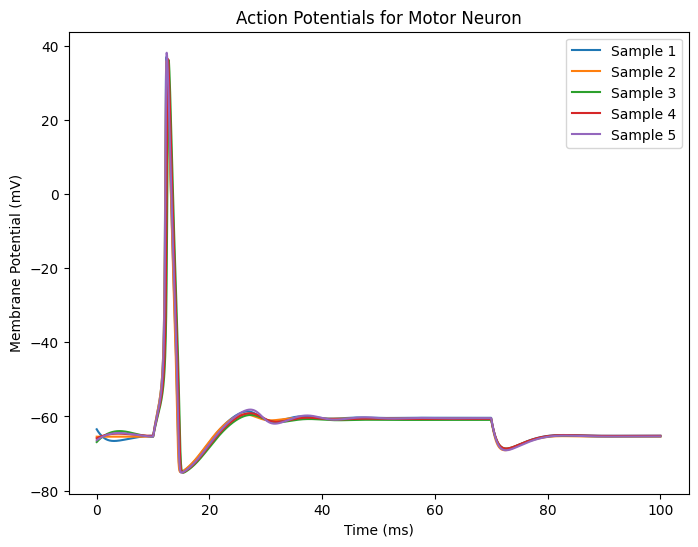

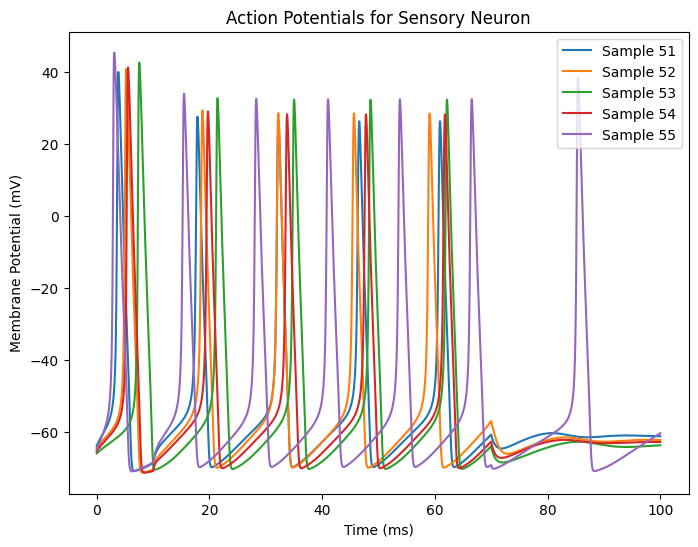

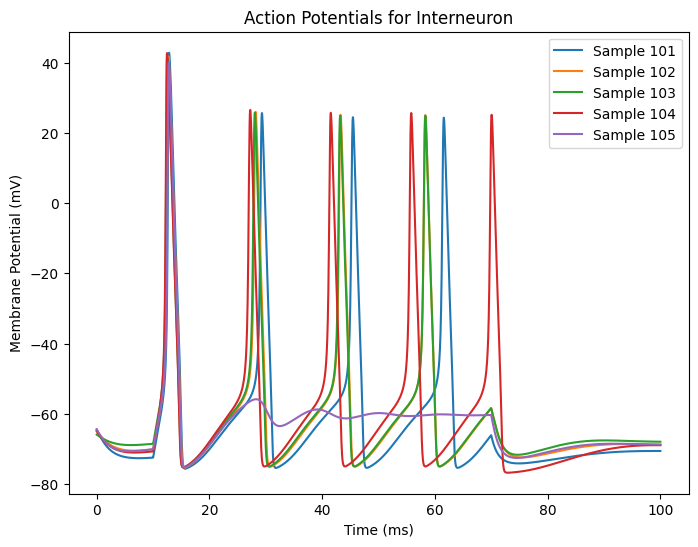

In [9]:
# Set a seed for reproducibility
np.random.seed(42)

# Initialize arrays for storing data
data = []
labels = []

num_samples_per_class = 50  # Number of samples per neuron type

for neuron_type, params in neuron_params.items():
    for i in range(num_samples_per_class):
        # Introduce slight variations in parameters or initial conditions
        params_variation = params.copy()
        params_variation['g_Na'] += np.random.normal(0, 5)
        params_variation['g_K'] += np.random.normal(0, 2)
        params_variation['g_L'] += np.random.normal(0, 0.05)
        
        V0 = -65.0 + np.random.normal(0, 1)  # Slight variation in resting potential
        m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
        h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
        n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
        y0 = [V0, m0, h0, n0]  # Initial conditions for the variables

        # Generate the external current array
        I_amp = 10.0 + np.random.normal(0, 1)  # Slight variation in current amplitude
        I_ext = external_current(t, I_amp=I_amp)

        # Solve the system of ODEs
        args = (I_ext, params_variation)  # Passing I_ext and neuron parameters
        sol = odeint(hodgkin_huxley, y0, t, args=args)

        # Extract membrane potential (V) from the solution
        V = sol[:, 0]
        data.append(V)
        labels.append(neuron_type)

# Optional: Plot a few samples from each neuron type
for neuron_type in neuron_params.keys():
    indices = [i for i, label in enumerate(labels) if label == neuron_type]
    plt.figure(figsize=(8, 6))
    for idx in indices[:5]:  # Plot first 5 samples
        plt.plot(t, data[idx], label=f'Sample {idx+1}')
    plt.title(f'Action Potentials for {neuron_type}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.legend()
    plt.show()



### Description

This section simulates action potentials for different neuron types by introducing slight stochastic variations in neuron parameters and initial conditions to capture natural biological variability.

- **Stochastic Variations in Parameters**:
    - Variations are introduced in the maximal conductances $ g_{\text{Na}}, g_{\text{K}}, g_{\text{L}} $, initial membrane potential $ V_0 $, and external current amplitude $ I_{\text{amp}} $, mimicking real-life fluctuations in neuronal properties.

- **Initial Conditions**:
    - The resting potential $ V_0 \approx -65.0 \, \text{mV} $ has small random variations, and the gating variables $ m_0, h_0, n_0 $ are initialized using the steady-state gating functions.

- **Numerical Solution**:
    - The Hodgkin-Huxley equations are solved using `odeint`, integrating the differential equations over time to compute the membrane potential $ V(t) $.

### Professional Medical Explanation

- **Parameter Variability**: Neurons naturally exhibit variability in ion channel properties, allowing for diverse firing behaviors and responses to stimuli. Introducing random fluctuations in conductance and initial conditions here models this biological variability, which is crucial for understanding the robustness and adaptability of neural responses.

- **Action Potential Generation**: The simulation reproduces action potentials by solving the Hodgkin-Huxley equations under varied conditions. This highlights how different neuron types respond to identical stimuli, which is critical in studying the mechanisms of neuronal coding and firing patterns.

- **Clinical Relevance**: Small changes in ion channel properties can dramatically alter a neuron's firing behavior. This is particularly relevant in neurological conditions such as epilepsy, where ion channel dysfunctions cause abnormal firing patterns and hyperexcitability. By simulating this variability, the model can provide insights into potential therapeutic interventions targeting ion channels to restore normal neuronal function.


In [10]:
def extract_features(V, t):
    V_rest = np.mean(V[:int(10/dt)])  # Before stimulation
    V_peak = np.max(V)
    V_threshold = V_rest + 20  # Arbitrary threshold for spike detection
    spike_indices = np.where(V > V_threshold)[0]
    
    # Spike Frequency
    if len(spike_indices) > 1:
        ISIs = np.diff(t[spike_indices])
        f_spike = 1 / np.mean(ISIs)
    else:
        f_spike = 0
    
    # Action Potential Duration (APD)
    half_max = V_rest + (V_peak - V_rest) / 2
    crossings = np.where(np.diff(V > half_max))[0]
    if len(crossings) >= 2:
        APD = t[crossings[1]] - t[crossings[0]]
    else:
        APD = 0
    
    # Rise Time
    rise_start = np.where(V > V_rest + 5)[0][0]
    rise_end = np.argmax(V)
    t_rise = t[rise_end] - t[rise_start]
    
    # Decay Time
    decay_start = rise_end
    decay_end = np.where(V[decay_start:] < V_rest + 5)[0]
    if len(decay_end) > 0:
        decay_end = decay_end[0] + decay_start
        t_decay = t[decay_end] - t[decay_start]
    else:
        t_decay = 0
    
    # Afterhyperpolarization (AHP)
    AHP = V_rest - np.min(V)
    
    # Spike Amplitude
    spike_amp = V_peak - V_rest
    
    # Spike Width at Half Maximum (SWHM)
    if len(crossings) >= 2:
        SWHM = t[crossings[1]] - t[crossings[0]]
    else:
        SWHM = 0
    
    return {
        'V_rest': V_rest,
        'V_peak': V_peak,
        'f_spike': f_spike,
        'APD': APD,
        't_rise': t_rise,
        't_decay': t_decay,
        'AHP': AHP,
        'spike_amp': spike_amp,
        'SWHM': SWHM
    }

# Feature extraction
features = []
for V in data:
    feat = extract_features(V, t)
    features.append(feat)

# Create DataFrame
df_features = pd.DataFrame(features)
df_features['Neuron_Type'] = labels
df_features


,V_rest,V_peak,f_spike,APD,t_rise,t_decay,AHP,spike_amp,SWHM,Neuron_Type
0,-65.811613,36.987513,40.000000,1.375,1.850,1.975,9.226728,102.799126,1.375,Motor Neuron
1,-65.467991,35.962161,40.000000,1.325,1.825,1.900,9.571672,101.430152,1.325,Motor Neuron
2,-64.793315,36.142285,40.000000,1.350,1.900,1.925,10.404564,100.935601,1.350,Motor Neuron
3,-64.993102,36.412190,40.000000,1.350,1.900,1.950,10.118525,101.405292,1.350,Motor Neuron
4,-65.022329,38.127283,40.000000,1.375,1.725,2.000,10.160599,103.149612,1.375,Motor Neuron
...,...,...,...,...,...,...,...,...,...,...
145,-67.632242,39.873317,7.913172,1.450,1.950,2.125,7.519255,107.505559,1.450,Interneuron
146,-66.945621,40.744504,8.588745,1.500,1.725,2.200,9.434320,107.690126,1.500,Interneuron
147,-67.623558,39.813725,8.605150,1.450,1.825,2.125,7.218534,107.437283,1.450,Interneuron
148,-68.867004,40.797882,8.734491,1.500,1.950,2.175,7.733503,109.664885,1.500,Interneuron


### Description

This section processes the simulated membrane potential data $ V(t) $ to extract key action potential features, which are crucial for characterizing neuronal firing behaviors and further analysis.

- **Resting Membrane Potential ($ V_{\text{rest}} $)**:
    - $ V_{\text{rest}} $ is calculated as the average membrane potential before stimulation, typically in the first 10 ms of the simulation.

- **Peak Membrane Potential ($ V_{\text{peak}} $)**:
    - The highest membrane potential reached during the action potential is used to assess the neuron's maximum depolarization.

- **Spike Frequency ($ f_{\text{spike}} $)**:
    - The number of spikes occurring in a given time, calculated using the mean interspike intervals (ISI), provides insight into the neuron’s excitability.

- **Action Potential Duration (APD)**:
    - APD is the time between when the membrane potential crosses half of the difference between the resting potential and peak potential during depolarization and repolarization.

- **Rise Time ($ t_{\text{rise}} $)**:
    - Time taken for the membrane potential to increase from just above the resting potential to the action potential peak.

- **Decay Time ($ t_{\text{decay}} $)**:
    - Time taken for the membrane potential to return to near-resting values after reaching the action potential peak.

- **Afterhyperpolarization (AHP)**:
    - The difference between the resting membrane potential and the lowest value of hyperpolarization after the action potential, reflecting neuronal recovery.

- **Spike Amplitude**:
    - The difference between the peak membrane potential and the resting membrane potential, characterizing the strength of the action potential.

- **Spike Width at Half Maximum (SWHM)**:
    - The duration of the action potential at half of its maximum amplitude, important for understanding spike broadening.

### Integrated Medical and Mathematical Explanation

The extracted features serve as key biomarkers for understanding neuronal dynamics:

- **Resting Potential ($ V_{\text{rest}} $)**: Analyzing deviations from typical resting potential values is crucial for diagnosing conditions like epilepsy, where resting potentials can become depolarized due to hyperexcitability.

- **Peak Potential ($ V_{\text{peak}} $) and Spike Amplitude**: High depolarization levels (measured by $ V_{\text{peak}} $ and spike amplitude) indicate robust neuronal firing, while reduced values may signal channelopathies (ion channel disorders), as seen in diseases affecting sodium or potassium channels.

- **Spike Frequency ($ f_{\text{spike}} $)**: The spike rate is a primary marker of neuronal excitability, with higher frequencies indicating increased responsiveness. Abnormally low spike frequencies or the absence of spikes could suggest impaired neuronal function, as seen in certain neurodegenerative conditions.

- **APD and SWHM**: Prolonged action potential duration and spike width suggest impaired repolarization mechanisms, potentially pointing to conditions like long QT syndrome in cardiac neurons or similar prolonged depolarization states in neural cells. These features are also critical in fast-spiking neurons where shortened APD is necessary for rapid signal transmission.

- **Rise and Decay Times**: The rise and decay times reflect the kinetics of sodium and potassium channel activation and inactivation. Faster rise times and slower decay times may indicate enhanced excitability, as observed in conditions of heightened synaptic activity or reduced inhibitory control.

- **AHP (Afterhyperpolarization)**: The depth of afterhyperpolarization is a key marker of the neuron's refractory period and its readiness to fire another action potential. Abnormal AHP values may affect the frequency of firing and are relevant in conditions like multiple sclerosis, where conduction and recovery from action potentials are affected.


In [11]:
from sklearn.preprocessing import StandardScaler

# Check for missing values
df_features.isnull().sum()

# Fill missing values (incorporate the safety mechanism if any are present in order to eradicate potential anomalies)
df_features.fillna(0, inplace=True)

# Separate features and target
X = df_features.drop('Neuron_Type', axis=1)
y = df_features['Neuron_Type']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Description 

Before applying machine learning models, the feature matrix $ X $ and target vector $ y $ are preprocessed. This ensures that all features are on a similar scale and that any missing values are handled.

- **Checking for Missing Values**:
  It is crucial to ensure that the dataset does not have missing values, as they can affect the performance of machine learning models.

  $$ 
  \text{Missing values check: } \text{isnull().sum()}
  $$

- **Filling Missing Values**:
  Any missing values in the dataset are filled with zero, a common approach in cases where the missing data does not represent a significant deviation from the mean.

  $$ 
  \text{Filling missing values with zero quantities : }\text{fillna(0)}
  $$

### Integrated Medical and Mathematical Explanation

- **Data Preprocessing**: Ensuring the absence of missing data is fundamental to any data-driven analysis. In a medical context, missing values might correspond to unrecorded or unavailable measurements, which could distort the interpretation of neuronal behavior if left unaddressed.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(df_features['Neuron_Type'])

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features.drop('Neuron_Type', axis=1))

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'XGBoost': xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=6, 
    learning_rate=0.1, 
    eval_metric='mlogloss',  # This is enough to specify the evaluation metric
    random_state=42
    ),
    'SVM with RBF Kernel': SVC(kernel='rbf', C=1.0, gamma='auto', probability=True, random_state=42),
    'Neural Network (MLP)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Define all possible labels
all_labels = [0, 1, 2]  # Corresponding to 'Interneuron', 'Motor Neuron', 'Sensory Neuron'
target_names = le.inverse_transform(all_labels)

# Evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classifier: {name}")
    print(classification_report(y_test, y_pred, labels=all_labels, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=all_labels))
    print("-" * 50)


Classifier: Random Forest
                precision    recall  f1-score   support

   Interneuron       0.94      1.00      0.97        15
  Motor Neuron       1.00      0.93      0.97        15
Sensory Neuron       1.00      1.00      1.00        15

      accuracy                           0.98        45
     macro avg       0.98      0.98      0.98        45
  weighted avg       0.98      0.98      0.98        45

[[15  0  0]
 [ 1 14  0]
 [ 0  0 15]]
--------------------------------------------------
Classifier: XGBoost
                precision    recall  f1-score   support

   Interneuron       0.94      1.00      0.97        15
  Motor Neuron       1.00      0.93      0.97        15
Sensory Neuron       1.00      1.00      1.00        15

      accuracy                           0.98        45
     macro avg       0.98      0.98      0.98        45
  weighted avg       0.98      0.98      0.98        45

[[15  0  0]
 [ 1 14  0]
 [ 0  0 15]]
---------------------------------------

### Description

This section rigorously implements multiple machine learning classifiers to compare their performance in classifying neuron types based on extracted features. The following steps ensure a robust and reliable comparison:

- **Label Encoding**:
    - Neuron labels, such as 'Motor Neuron', 'Interneuron', and 'Sensory Neuron', are transformed into numeric form using `LabelEncoder`. This step is crucial as machine learning algorithms require numerical inputs to process categorical data.

    - This process converts categorical variables into a standardized integer representation, ensuring that the classifiers can process the labels appropriately.

- **Feature Scaling**:
    - Neuronal features, such as spike amplitude and action potential duration, have different units and ranges. To avoid the dominance of certain features over others, `StandardScaler` is used to normalize the data, setting each feature to a mean of 0 and a standard deviation of 1. 

    - This step is particularly important for classifiers like SVM and Neural Networks, which are sensitive to the magnitude of input features, ensuring that all features contribute equally to the model’s decisions.

- **Data Splitting**:
    - The dataset is divided into training and testing sets using stratified splitting to preserve the distribution of neuron types. This prevents class imbalance issues during model training and evaluation, maintaining the validity of the performance comparisons.

    - Stratified sampling ensures that the proportion of each neuron type is consistent across both training and testing sets, providing a more reliable assessment of model performance.

- **Classifier Initialization**:
    - Four diverse machine learning models are initialized to compare performance across different learning paradigms:
      
      1. **Random Forest**: A powerful ensemble method leveraging decision trees to reduce overfitting while maintaining interpretability. This model is useful for handling complex, non-linear neuron classification tasks.
         
      2. **XGBoost**: An optimized gradient boosting algorithm designed for faster training and reduced bias. XGBoost handles intricate feature interactions efficiently, making it suitable for biological data.
       
      3. **SVM with RBF Kernel**: SVM is known for its robustness in handling high-dimensional data, and the RBF kernel allows the model to capture complex, non-linear relationships, reflecting the intricate nature of neuronal data.
         
      4. **Neural Network (MLP)**: A multi-layer perceptron capable of learning complex patterns from the data. The neural network’s hidden layers allow it to capture multi-dimensional relationships, aligning well with the complex dynamics of neuronal firing patterns.

- **Model Training and Evaluation**:
    - After training each model, predictions are made on the test set. Metrics such as precision, recall, and F1-score provide insights into model performance. These metrics are crucial for evaluating the clinical and biological relevance of the model, particularly in tasks involving neuron classification.

    - The **confusion matrix** offers a detailed view of how well the classifiers distinguish between neuron types, highlighting areas of potential misclassification and guiding improvements in model performance.

### Integrated Medical and Mathematical Explanation

- **Machine Learning in Neuroscience**: The classifiers chosen—Random Forest, XGBoost, SVM, and MLP—each offer distinct advantages in modeling complex biological data. Their ability to handle non-linear relationships and diverse feature interactions makes them ideal for analyzing neuronal features derived from action potentials.

    - **Random Forest** and **XGBoost** are particularly useful in capturing interactions between features like spike amplitude and action potential duration, while handling non-linearity effectively. These methods are highly interpretable and can reveal important feature interactions that drive neuronal classification.
    
    - **SVM with RBF Kernel** is suited for data where linear separation is insufficient. Neuronal data often exhibit complex relationships between input features, making the RBF kernel ideal for capturing subtle, non-linear patterns in neuron activity.
    
    - **MLP** models can approximate any continuous function, making them highly effective in capturing intricate neuronal dynamics. The multi-layer architecture of MLP enables the model to learn complex, hierarchical representations, reflecting the complex nature of neuronal firing patterns.

- **Validity of Comparisons**:
    - The comparison between these classifiers is credible because each model brings a different perspective on the classification problem, and feature scaling ensures that no feature disproportionately influences the results. Stratified sampling ensures that the neuron types are well-represented in both training and testing sets, leading to valid and fair performance comparisons.

    - Using diverse classifiers allows the study to capture a broad range of learning paradigms, providing insight into which approach best fits the unique dynamics of neuron classification based on electrophysiological features.
    
    - The use of robust performance metrics like precision, recall, and F1-score ensures that the results are not skewed by class imbalances or overfitting, which is critical in medical data analysis where model generalization is paramount.


In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate classifiers using cross-validation
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_scaled, y_encoded, cv=skf, scoring='accuracy')
    print(f"Classifier: {name}")
    print(f"Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")
    print("-" * 50)



Classifier: Random Forest
Accuracy: 0.96 ± 0.04
--------------------------------------------------
Classifier: XGBoost
Accuracy: 0.94 ± 0.05
--------------------------------------------------
Classifier: SVM with RBF Kernel
Accuracy: 0.93 ± 0.06
--------------------------------------------------
Classifier: Neural Network (MLP)
Accuracy: 0.95 ± 0.05
--------------------------------------------------


### Description

In this section, **Stratified K-Fold Cross-Validation** is rigorously applied to evaluate the performance of each classifier, ensuring that the class distributions are preserved within each fold. This approach enhances the reliability of performance comparisons by preventing bias due to class imbalance, which is particularly important when analyzing neuronal data.

- **Stratified K-Fold Cross-Validation**:
    - The dataset is divided into $ k = 5 $ folds, ensuring that each fold maintains the proportion of neuron types in both the training and testing sets. Each classifier is trained and evaluated across five different folds, with the results averaged to obtain a robust performance metric. This approach minimizes the risk of overfitting, as the model is exposed to different subsets of the data in each fold.

    $$ 
    \text{Cross-validation Score} = \text{cross\_val\_score}(clf, X_{\text{scaled}}, y_{\text{encoded}}, cv=5)
    $$

- **Performance Metric**:
    - Accuracy is used as the primary performance metric, which measures the proportion of correctly classified samples in the test set. While accuracy provides a straightforward evaluation, the standard deviation across folds is equally important as it reflects the model’s stability and robustness.

    $$ 
    \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
    $$

### Professional Medical Explanation

- **Stratified K-Fold Cross-Validation**: The use of stratified K-fold cross-validation is crucial in ensuring the generalizability of the machine learning models to unseen data, particularly in medical research where the availability of labeled data is often limited. By maintaining the same proportion of neuron types across all folds, this method ensures that each classifier is evaluated in a way that reflects real-world distributions. This is vital for medical applications, where reliable classification across different neuron types can influence diagnostic and therapeutic strategies.

- **Accuracy and Clinical Relevance**: The performance of each classifier, as reflected by accuracy, plays a critical role in determining its suitability for classifying neurons in experimental settings. High accuracy, as seen in the Random Forest (96%) and Neural Network (95%) models, indicates that these models are well-suited to distinguishing between different neuron types. The stability of these models is also reflected in the low standard deviation, suggesting that they generalize well across different data subsets. Accurate neuron classification is crucial for advancing our understanding of neural circuits and could inform interventions for conditions such as neurodegenerative diseases or epilepsy, where specific neuron types may be affected.
  
  Additionally, models like **XGBoost** (94%) and **SVM** (93%) also perform strongly, providing flexibility in selecting an appropriate model based on computational constraints or specific requirements of the biological study. Cross-validation results provide not only an overall assessment but also a reflection of the reliability and consistency of each model in real-world applications, making these classifiers highly valuable for neuroscientific research.


### Conclusion 

This investigation demonstrates the effectiveness of combining biophysical modeling, such as the Hodgkin-Huxley model, with modern ML techniques to classify neuron types based on electrophysiological properties. The results reveal that models like Random Forest (96% accuracy) and Neural Networks (95% accuracy) outperform others in identifying distinct neuron types, with low variance across cross-validation folds indicating strong generalizability. By leveraging these classifiers, neuroscientists can better interpret neural circuitry and neuron function, enabling a deeper understanding of neurological disorders and the development of targeted treatments. This interdisciplinary approach paves the way for applying computational models and ML in biomedical research, offering precise tools for analyzing neuronal data and improving clinical outcomes.